In [ ]:
#@title Autoload all modules
%load_ext autoreload
%autoreload 2
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
from dataclasses import dataclass, field
import matplotlib.pyplot as plt
import io
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import importlib
import os
import functools
import itertools
import torch
from losses import get_optimizer
from models.ema import ExponentialMovingAverage

import torch.nn as nn
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_gan as tfgan
import tqdm
import io
import likelihood
import controllable_generation
from utils import restore_checkpoint
sns.set(font_scale=2)
sns.set(style="whitegrid")

import models
from models import utils as mutils
from models import ncsnv2
from models import ncsnpp
from models import ddpm as ddpm_model
from models import layerspp
from models import layers
from models import normalization
import sampling
from likelihood import get_likelihood_fn
from sde_lib import VESDE, VPSDE, subVPSDE
from sampling import (ReverseDiffusionPredictor, 
                      LangevinCorrector, 
                      EulerMaruyamaPredictor, 
                      AncestralSamplingPredictor, 
                      NoneCorrector, 
                      NonePredictor,
                      AnnealedLangevinDynamics)
import datasets

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

In [4]:
from configs.subvp import mvtec_ncsnpp_continuous as configs
config = configs.get_config()
config

data:
  category: hazelnut
  centered: true
  dataset: MVTEC
  dir_path: /DATA/Users/amahmood/GDrive/MVTec_AD/
  downsample_size: 256
  image_size: 128
  num_channels: 3
  random_flip: true
  uniform_dequantization: false
device: !!python/object/apply:torch.device
- cuda
- 0
eval:
  batch_size: 32
  begin_ckpt: 2
  bpd_dataset: test
  enable_bpd: true
  enable_loss: true
  enable_sampling: false
  end_ckpt: 3
  num_samples: 50000
model:
  attention_type: ddpm
  attn_resolutions: !!python/tuple
  - 16
  beta_max: 20.0
  beta_min: 0.1
  ch_mult: !!python/tuple
  - 1
  - 2
  - 2
  - 2
  conditional: true
  conv_size: 3
  dropout: 0.0
  ema_rate: 0.9999
  embedding_type: positional
  fir: true
  fir_kernel:
  - 1
  - 3
  - 3
  - 1
  fourier_scale: 16
  init_scale: 0.0
  name: ncsnpp
  nf: 64
  nonlinearity: swish
  normalization: GroupNorm
  num_res_blocks: 4
  num_scales: 2000
  progressive: none
  progressive_combine: sum
  progressive_input: residual
  resamp_with_conv: true
  resblock_

In [5]:
# Setup SDE
import sde_lib
sde = sde_lib.subVPSDE(
    beta_min=config.model.beta_min,
    beta_max=config.model.beta_max,
    N=config.model.num_scales,
)
sampling_eps = 1e-3

In [6]:
n_timesteps=10
eps=1e-5
torch.linspace(sde.T, eps, n_timesteps, device="cpu")

tensor([1.0000e+00, 8.8889e-01, 7.7778e-01, 6.6667e-01, 5.5556e-01, 4.4445e-01,
        3.3334e-01, 2.2223e-01, 1.1112e-01, 1.0000e-05])

In [16]:
t=torch.linspace(sde.T, eps, n_timesteps, device="cpu")
sigmas = sde.marginal_prob(torch.zeros_like(t), t)[1].numpy()
sigmas, sde.T

(array([9.9995679e-01, 9.9964756e-01, 9.9775028e-01, 9.8876739e-01,
        9.5613301e-01, 8.6600149e-01, 6.7983985e-01, 4.0167153e-01,
        1.2538469e-01, 1.0132790e-06], dtype=float32),
 1)

In [9]:
import pathlib

dataset_dir = f"{config.data.dir_path}/{config.data.category}"
dataset_builder = tfds.ImageFolder(dataset_dir)

train_dir = pathlib.Path(f"{dataset_dir}/train/")
test_dir = pathlib.Path(f"{dataset_dir}/test/")
seg_dir = pathlib.Path(f"{dataset_dir}/ground_truth/")
print(train_dir, test_dir, seg_dir, sep="\n")

LABELS = sorted(os.listdir(f"{test_dir}"))

dataset_builder.info, LABELS

/DATA/Users/amahmood/GDrive/MVTec_AD/hazelnut/train
/DATA/Users/amahmood/GDrive/MVTec_AD/hazelnut/test
/DATA/Users/amahmood/GDrive/MVTec_AD/hazelnut/ground_truth


(tfds.core.DatasetInfo(
     name='image_folder',
     full_name='image_folder/1.0.0',
     description="""
     Generic image classification dataset.
     """,
     homepage='https://www.tensorflow.org/datasets/catalog/image_folder',
     data_path='/DATA/Users/amahmood/GDrive/MVTec_AD//hazelnut',
     download_size=Unknown size,
     dataset_size=Unknown size,
     features=FeaturesDict({
         'image': Image(shape=(None, None, 3), dtype=tf.uint8),
         'image/filename': Text(shape=(), dtype=tf.string),
         'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=6),
     }),
     supervised_keys=('image', 'label'),
     disable_shuffling=False,
     splits={
         'ground_truth': <SplitInfo num_examples=70, num_shards=1>,
         'inlier': <SplitInfo num_examples=40, num_shards=1>,
         'ood': <SplitInfo num_examples=70, num_shards=1>,
         'test': <SplitInfo num_examples=110, num_shards=1>,
         'train': <SplitInfo num_examples=391, num_shards=1>,
     

In [87]:
test_ds = dataset_builder.as_dataset(
                split="test", shuffle_files=False
            )
test_labels = [int(x["label"]) for x in test_ds]
test_labels[:10]

[0, 4, 0, 1, 1, 4, 0, 1, 2, 2]

In [10]:
ckpt="latest"
fname=os.path.join(score_dir, f"ckpt_{ckpt}_scores.npz")
with np.load(fname, allow_pickle=True) as data:
    train_scores = data["train"]
    eval_scores = data["eval"]
    test_scores = data["test"]
    ood_scores = data["ood"]
    
fname=os.path.join(score_dir, f"ckpt_{ckpt}_score_norms.npz")
with np.load(fname, allow_pickle=True) as data:
    train_score_norms = data["train"]
    eval_score_norms = data["eval"]
    test_score_norms = data["test"]
    ood_score_norms = data["ood"]

In [33]:
from IPython import display
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid
from scipy.ndimage import (
    maximum_filter,
    percentile_filter,
    uniform_filter,
    median_filter,
    gaussian_filter)

def plot_scores(scores, sigmas, num_samples=5, original_included=False, vmax=None,
                thresh_q=None, cmap="rocket", smooth = False):

  n_sigmas = sigmas.shape[0]
  cols = scores.shape[1]
  fig = plt.figure(figsize=(10*num_samples, 10*cols))
  grid = ImageGrid(fig, 111,  # similar to subplot(111)
                    nrows_ncols=(num_samples, cols),  # creates grid of axes
                    direction="row",
                    axes_pad=0.1,  # pad between axes in inch.
                    share_all=True,
                    cbar_location="right",
                    cbar_mode="edge",
                    cbar_size="5%",
                    cbar_pad="1%",
                    label_mode = "1"
                    )
  scores = np.concatenate(scores[:num_samples, ...])
  for i, (ax, cax, s) in enumerate(zip(grid, grid.cbar_axes, scores)):
      # Iterating over the grid returns the Axes.
      im = s ** 2

      _vmax = vmax
      _cmap = cmap

      if original_included and i % cols == 0:
        _cmap="viridis"
        _vmax = None

      if i % cols > 0 or not original_included:
        if im.shape[-1] > 1:
            im = np.mean(im, axis=-1)
        
        if thresh_q:
          thresh = np.quantile(im, thresh_q)
          im [im < thresh] = 0
        if smooth:
          im = gaussian_filter(im, sigma=1.0, mode="constant")
#           im = uniform_filter(im, 7)
        

      im = ax.imshow(im, cmap=_cmap, vmax=_vmax)
      fig.colorbar(im, cax=cax)
      ax.grid(False)
      
      if original_included:
        if i > 0 and i <= n_sigmas:
          ax.set_title(f"s={sigmas[i-1]:.3f}", fontsize=14)
      elif i < n_sigmas:
        ax.set_title(f"s={sigmas[i]:.3f}", fontsize=14)

  plt.show()
  return

In [34]:
viz_tensors = np.transpose(eval_scores,[1,0,3,4,2])
viz_tensors.shape

(39, 10, 128, 128, 3)

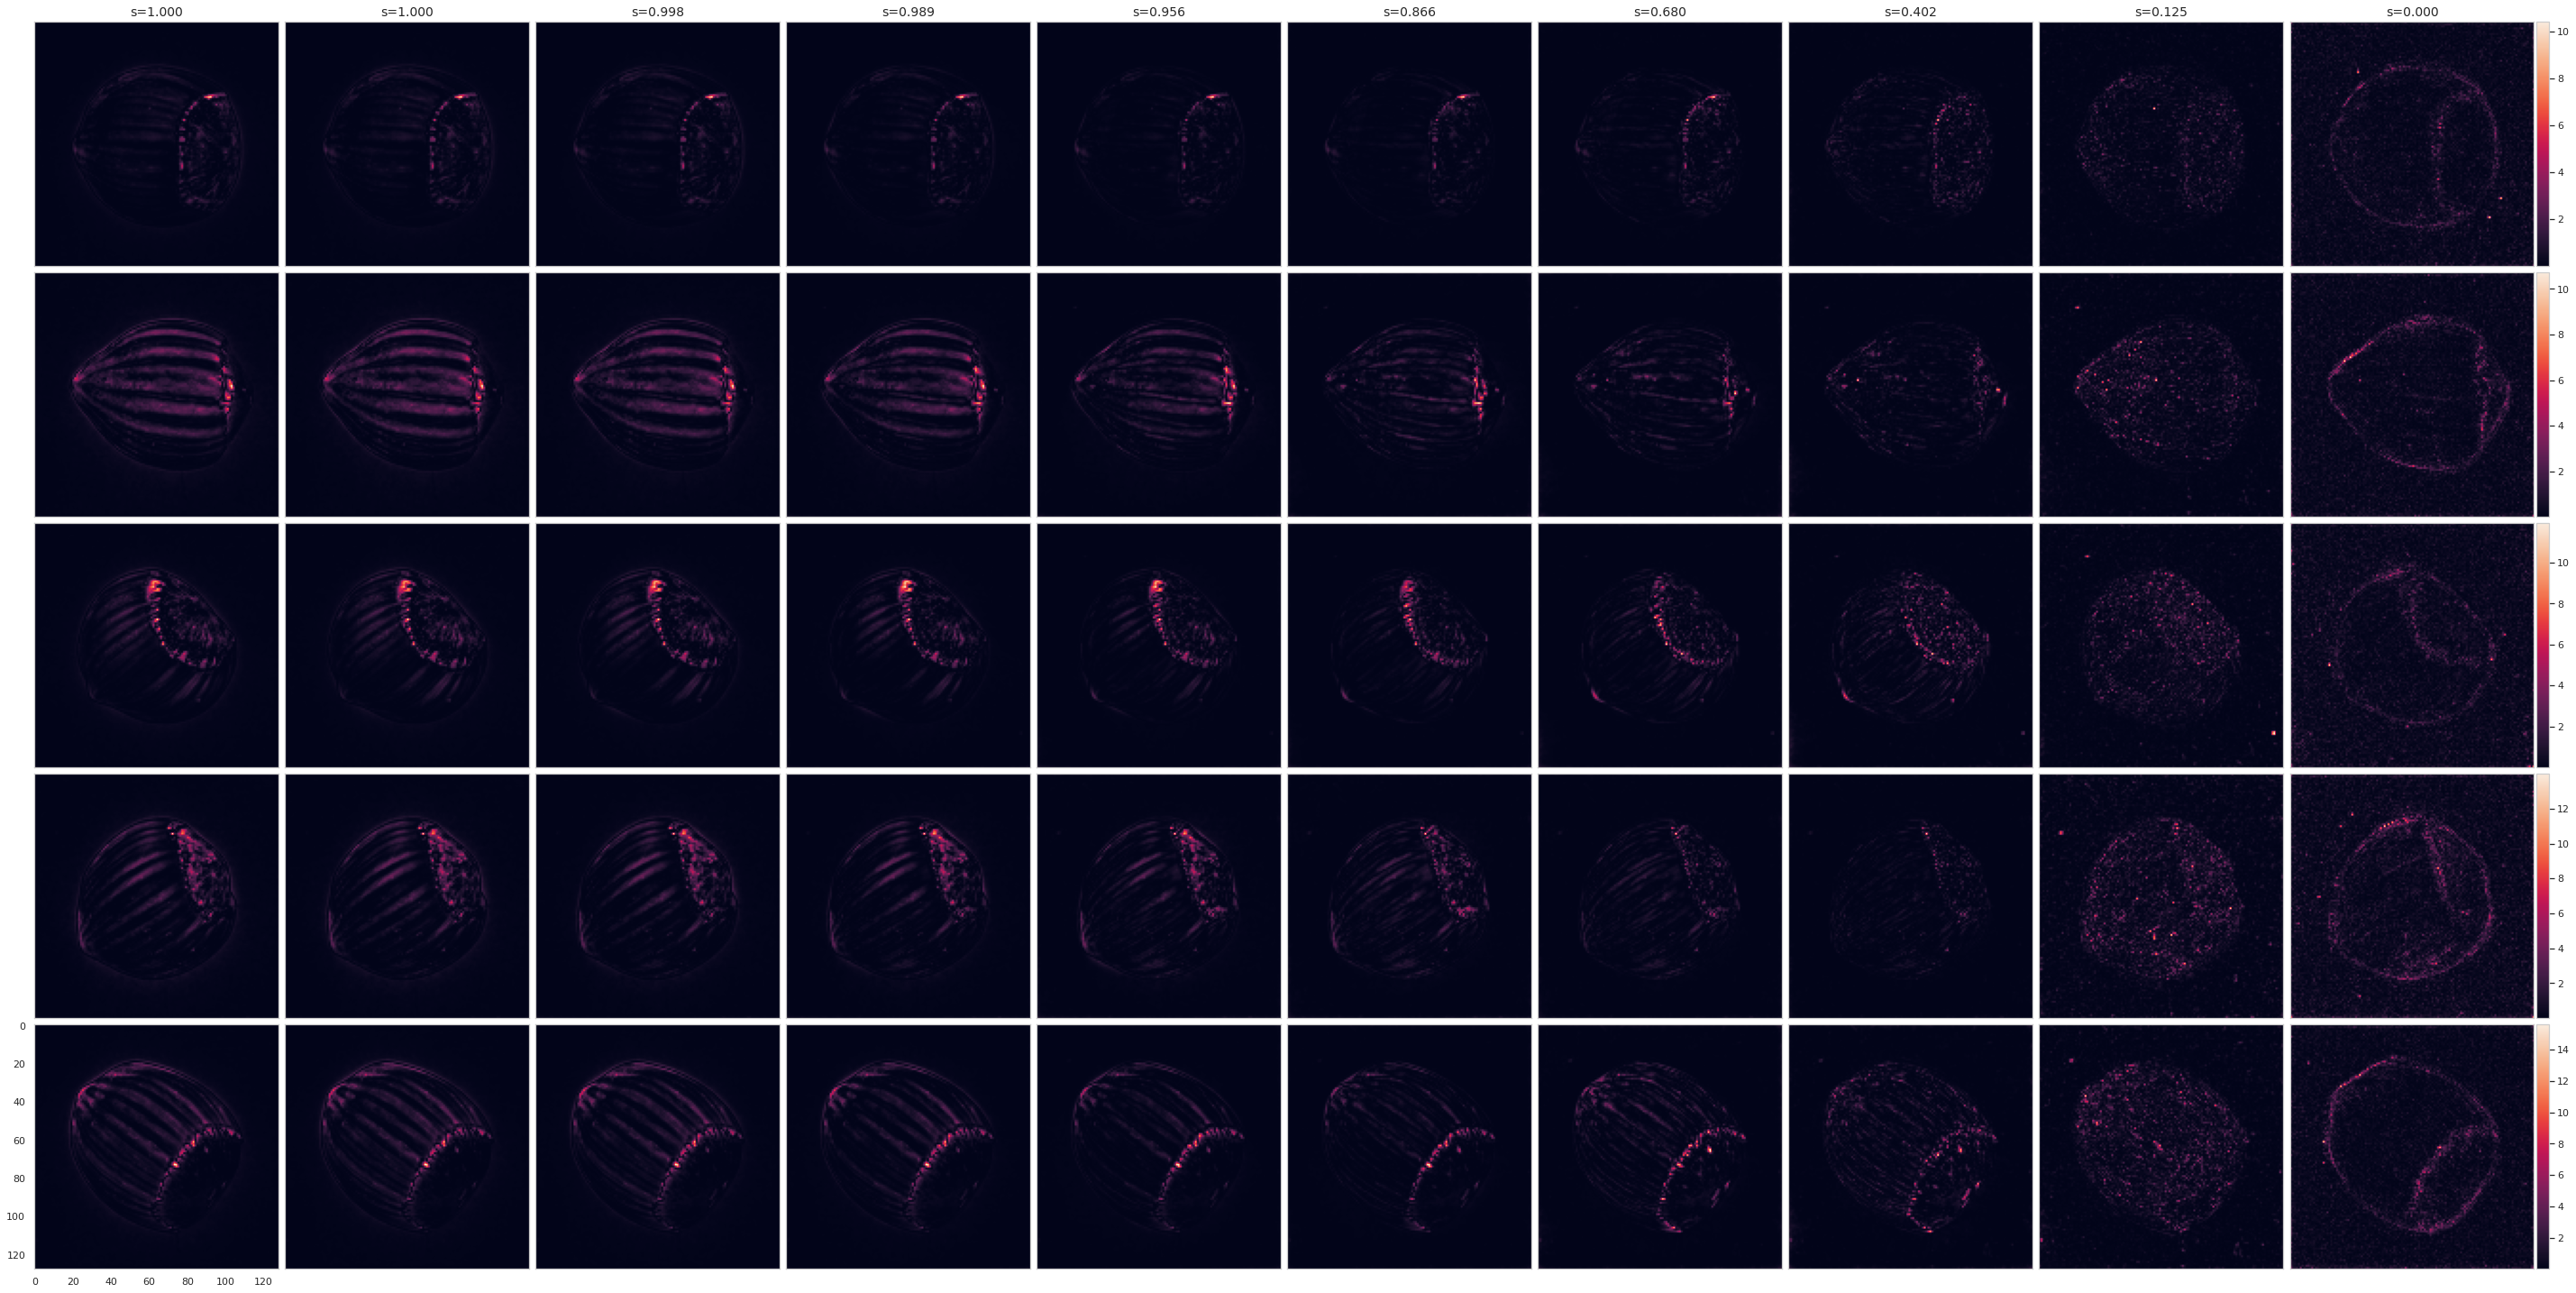

In [35]:
plot_scores(viz_tensors, sigmas)

In [36]:
viz_ood = np.transpose(ood_scores,[1,0,3,4,2])
viz_ood.shape

(70, 10, 128, 128, 3)

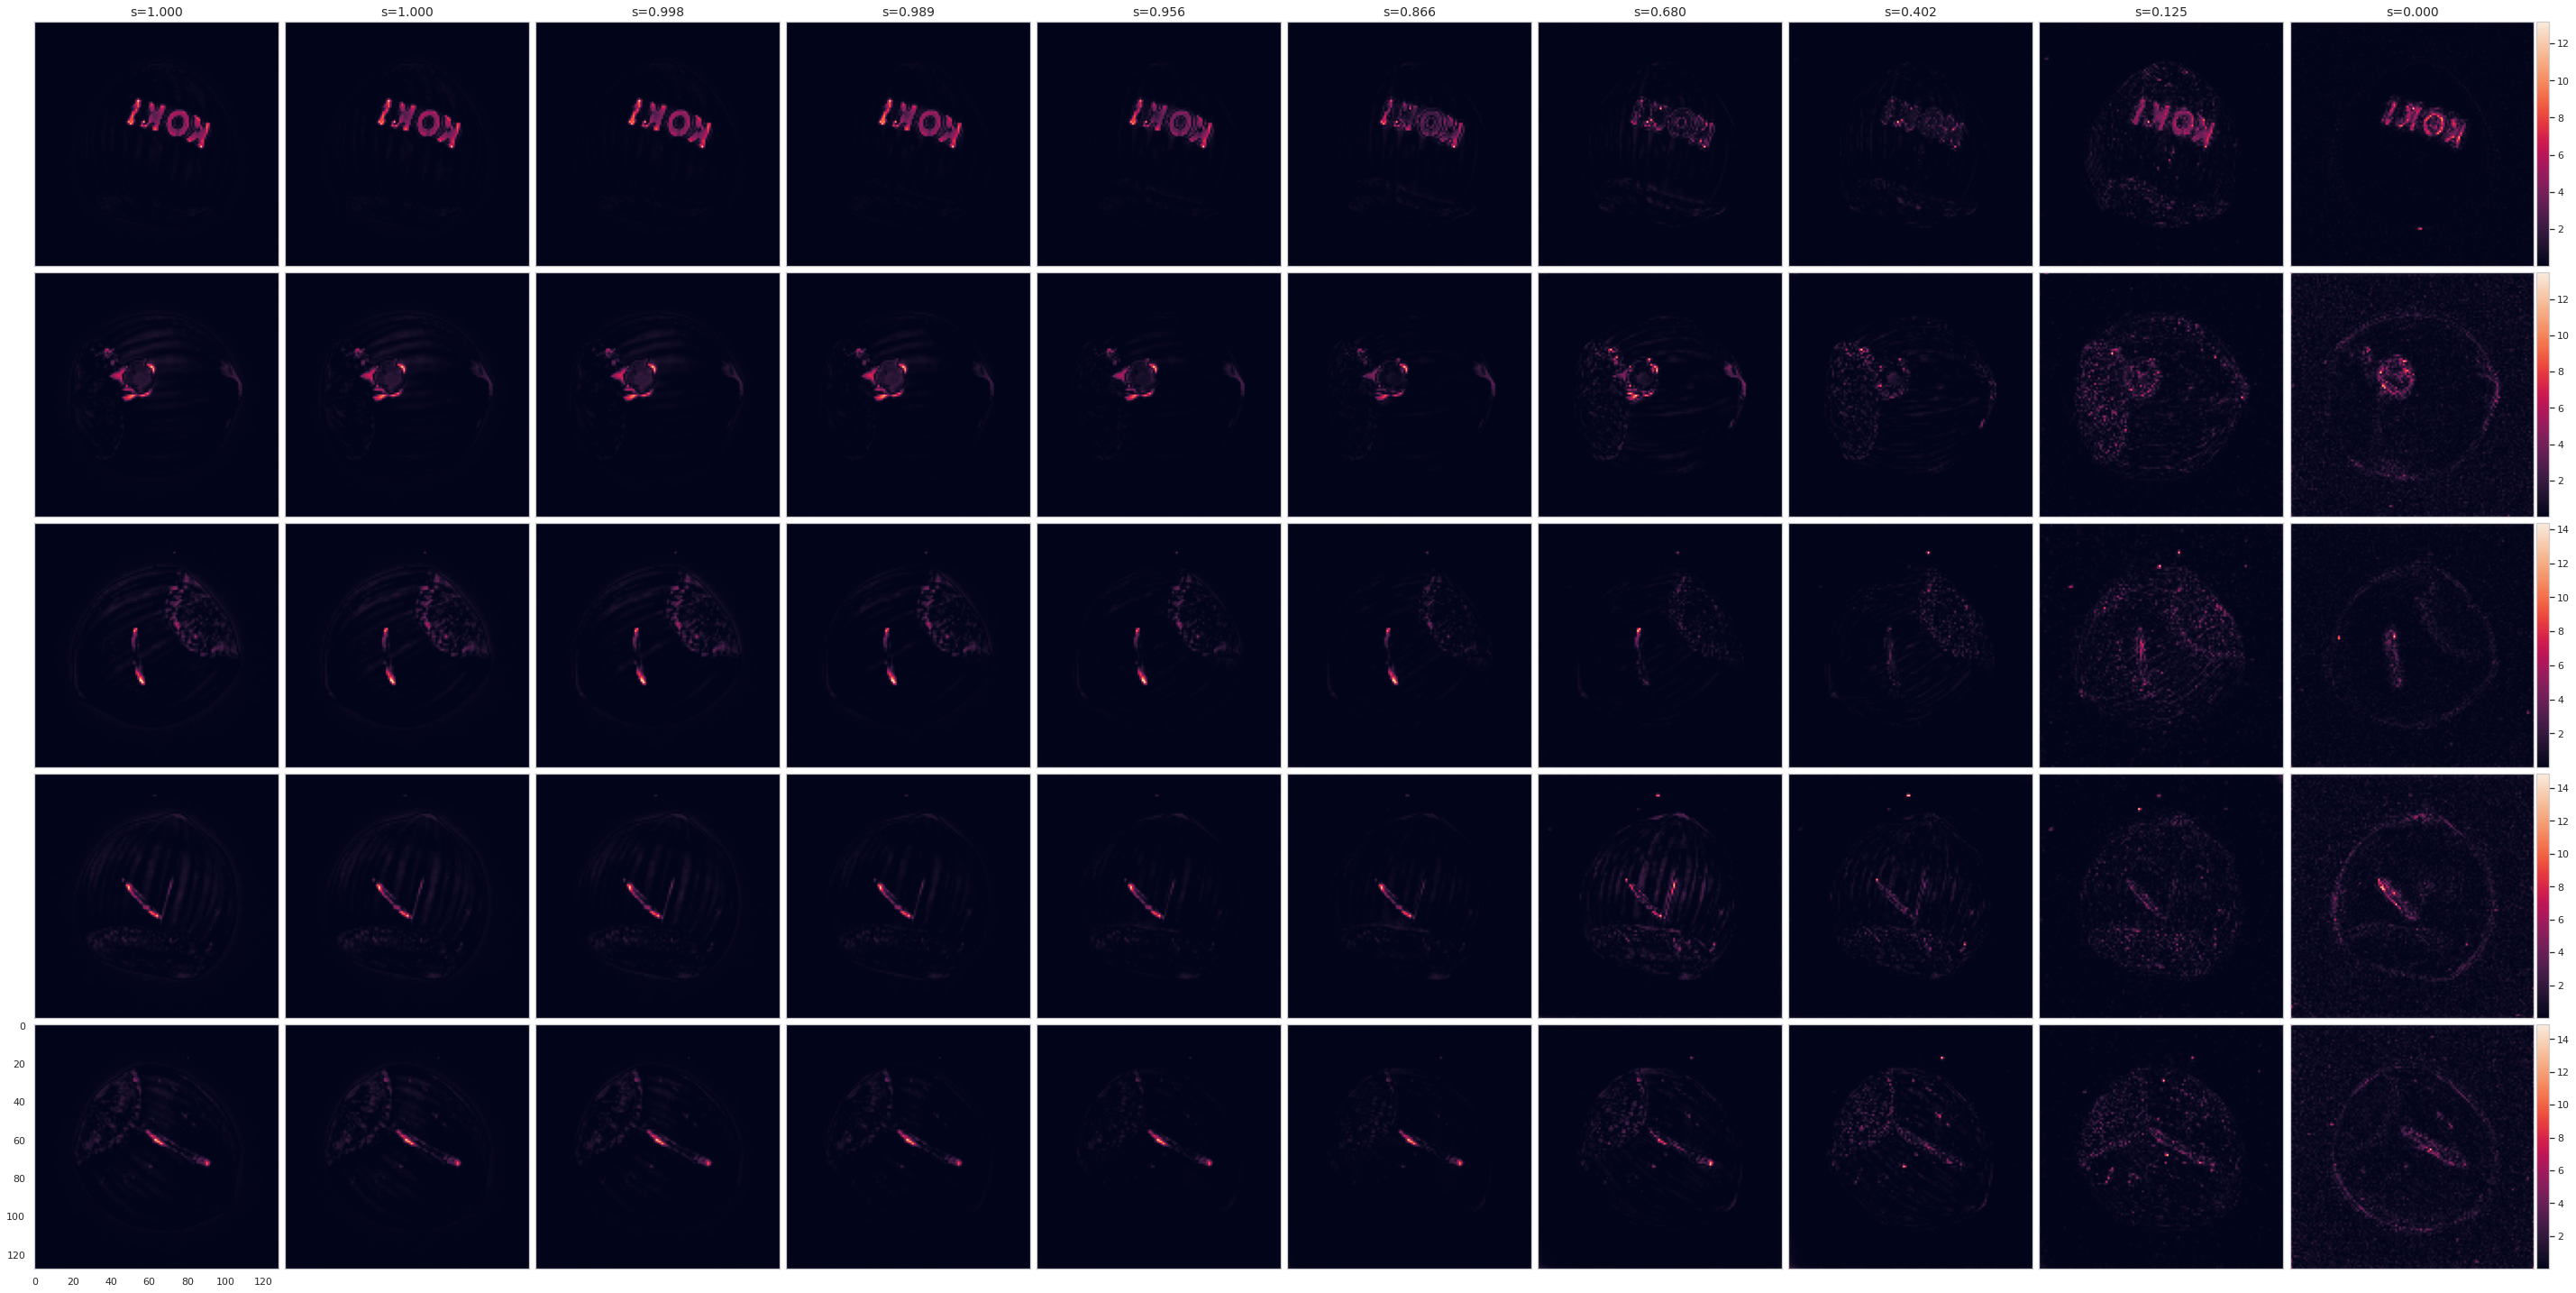

In [37]:
plot_scores(viz_ood, sigmas)

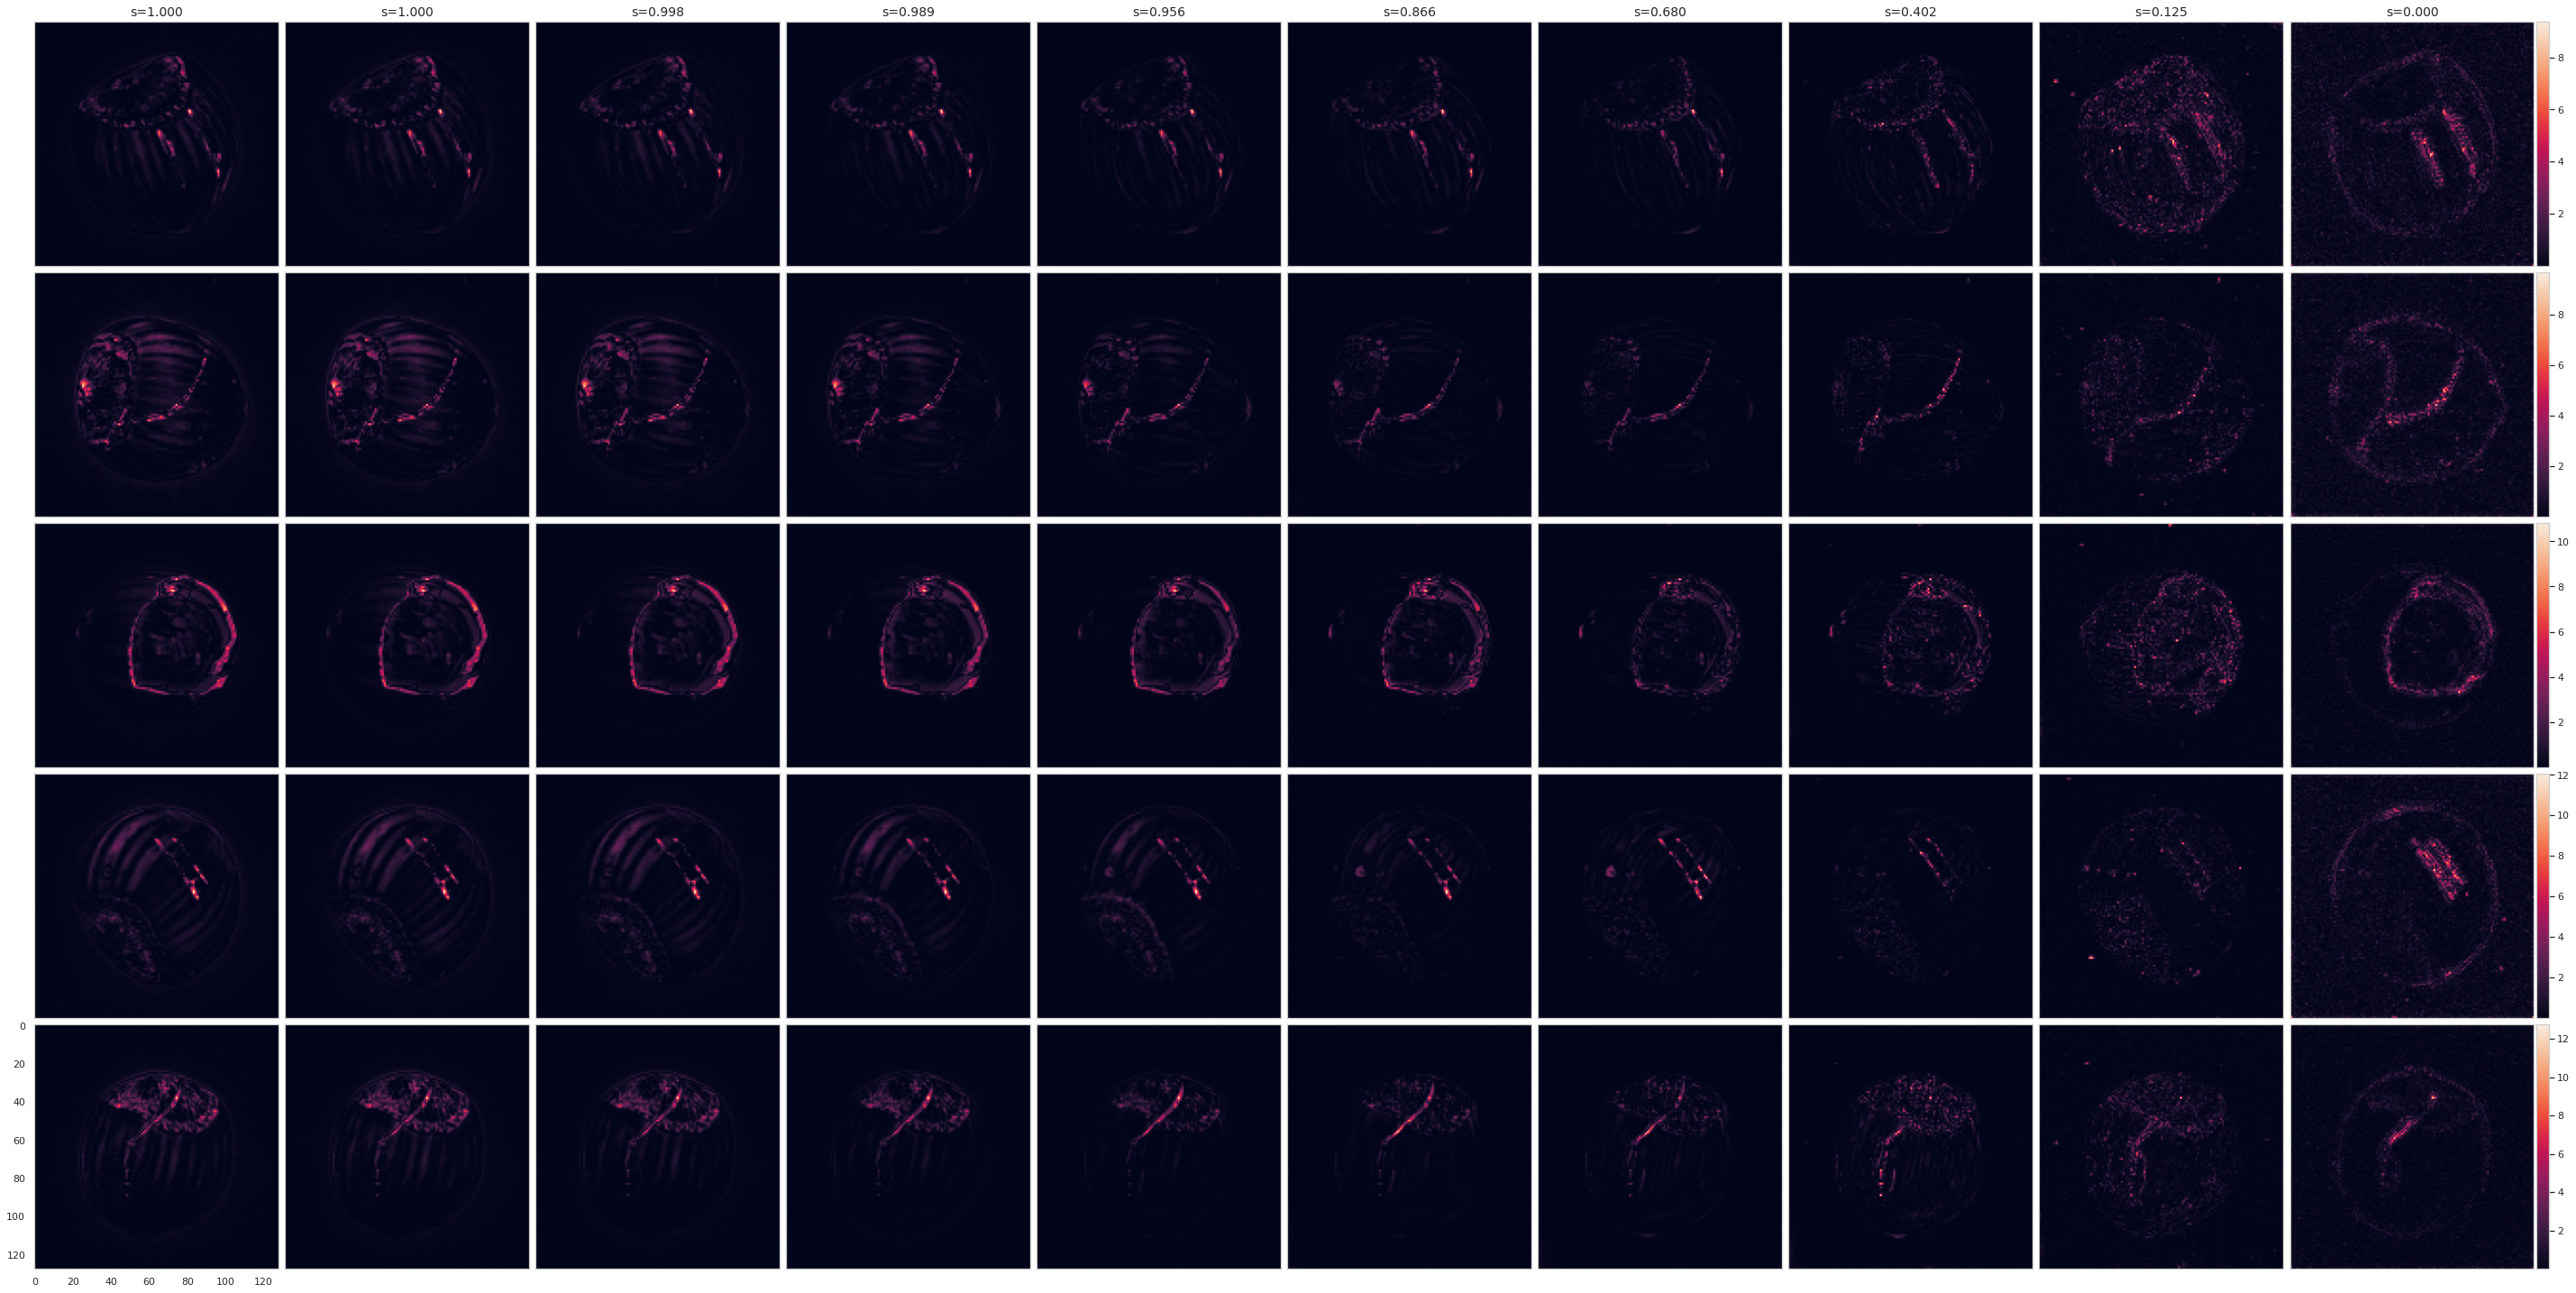

In [71]:
plot_scores(viz_ood[15:20,...], sigmas)

In [66]:
#@title Visualization code

def image_grid(x):
  size = config.data.image_size
  channels = 1#config.data.num_channels
  img = x.reshape(-1, size, size, channels)
  w = int(np.sqrt(img.shape[0]))
  img = img.reshape((w, w, size, size, channels)).transpose((0, 2, 1, 3, 4)).reshape((w * size, w * size, channels))
  return img

def show_samples(x):
#   x = x.permute(0, 2, 3, 1).detach().cpu().numpy()
  img = image_grid(x)
  vmax=np.quantile(img, 0.999)
  plt.figure(figsize=(12,12), dpi=100)
  plt.axis('off')
  plt.imshow(img, vmax=vmax)
  plt.show()

In [56]:
viz_ood_mean = tf.reduce_mean(ood_scores, axis=[0,2], keepdims=True).numpy()[0,:64,...]
viz_ood_mean.shape

(64, 1, 128, 128)

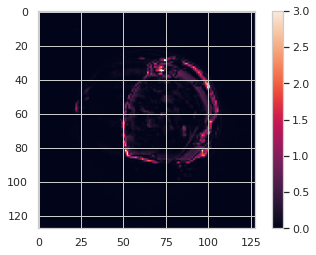

In [69]:
plt.imshow(viz_ood_mean[17,0]**2, vmax=3)
plt.colorbar()

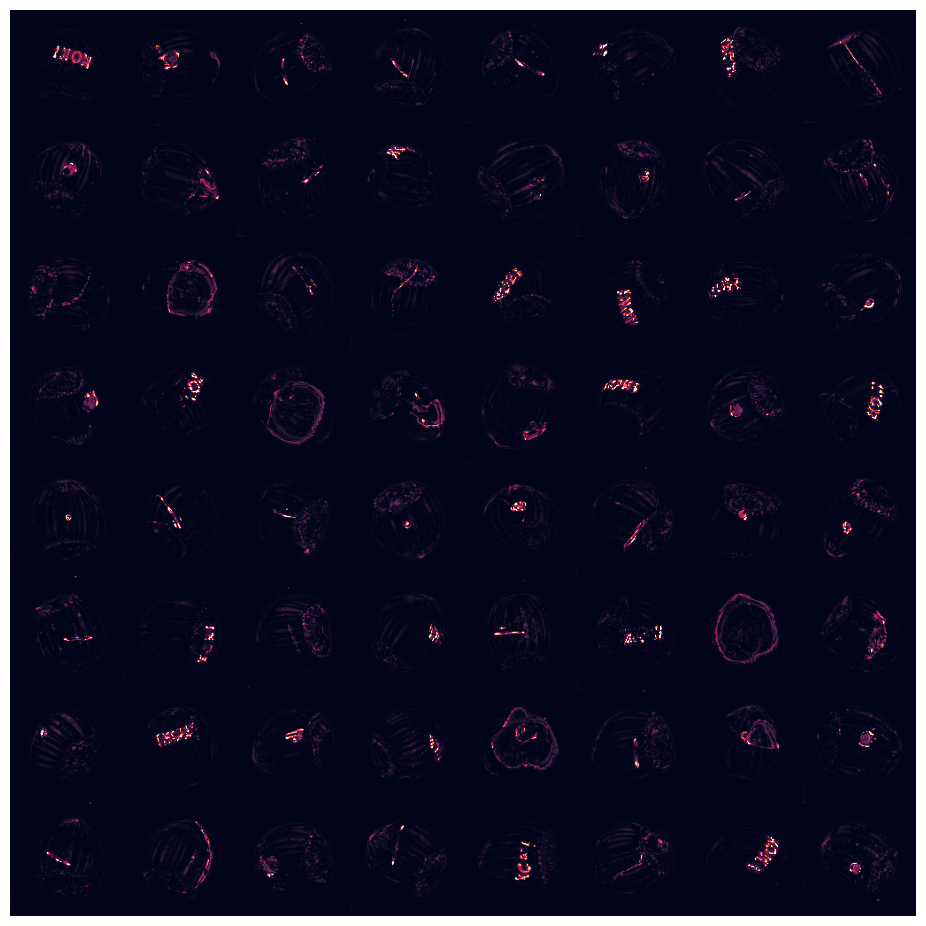

In [67]:
show_samples(viz_ood_mean**2)

### Climb scores